# 优化算法

## SGD随机梯度下降:
在GD中，每次迭代会用到**全部**训练数据，而在SGD中，每次迭代可以只用**一个**训练数据来更细参数。

## Minibatch GD 小批量随机梯度下降  
GD中使用完整数据集来计算梯度并更新参数， SGD中一次处理一个训练样本来取得进展。 二者各有利弊：每当数据非常相似时，梯度下降并不是非常“数据高效”。 而由于CPU和GPU无法充分利用向量化，随机梯度下降并不特别“计算高效”。小批量随机梯度下降就是折中方案。

## AdaGrad算法：
在训练过程中能够自动调整学习率。

## Adam算法  
* SGD：随机梯度下降在解决优化问题时比梯度下降更有效。  
* minibatch GD：在一个小批量中使用更大的观测值集，可以通过向量化提供额外效率。这是高效的多机、多GPU和整体并行处理的关键。  
* 动量法：添加了一种机制，用于汇总过去梯度的历史以加速收敛。
* AdaGard：我们使用每坐标缩放来实现计算效率的预处理。
* Adadelta：我们通过学习率的调整来分离每个坐标的缩放。

Adam算法将这些技术汇总到一个高校的学习算法中。但是Adam并非没有问题，有时可能由于方差控制不良而发散。

## 学习率调度器  

* 多项式衰减的一种替代方案是乘法衰减，即$\eta_{t+1} \leftarrow \eta_t \cdot \alpha$，为了防止学习率衰减超出合理的下限，更新方程经常修改为 $\eta_{t+1} \leftarrow \mathop{\mathrm{max}}(\eta_{\mathrm{min}}, \eta_t \cdot \alpha)$。
* 保持分段稳定的学习率，而且每隔一段时间就一定程度降低学习率。 具体地说，给定一组降低学习率的时间，例如 𝑠={5,10,20} 每当 𝑡∈𝑠 时降低$\eta_{t+1} \leftarrow \eta_t \cdot \alpha$。 假设每步中的值减半，我们可以按如下方式实现这一点。
* 余弦调度器是 [Loshchilov & Hutter, 2016]提出的一种启发式算法。 它所依据的观点是：我们可能不想在一开始就太大地降低学习率，而且可能希望最终能用非常小的学习率来“改进”解决方案。 这产生了一个类似于余弦的调度，函数形式如下所示，学习率的值在 𝑡∈[0,𝑇] 之间。$$\eta_t = \eta_T + \frac{\eta_0 - \eta_T}{2} \left(1 + \cos(\pi t/T)\right)$$这里 𝜂0 是初始学习率， 𝜂𝑇 是当 𝑇 时的目标学习率。 此外，对于 𝑡>𝑇 ，我们只需将值固定到 𝜂𝑇 而不再增加它。 在下面的示例中，我们设置了最大更新步数 𝑇=20 。

# NLP：预训练

## 词嵌入 Word2Vec

将单词映射到向量的技术被称为词嵌入。词嵌入逐渐成为NLP的基础知识。

one-hot encoding很容易构建，但通常不是一个好的选择。一个主要的原因是它不能准确表达不同词之间的相似程度。 例如，“bank”（可以译作银行或者河岸）的向量表示在 “go to the bank to deposit some money”（去银行存点钱） 和“go to the bank to sit down”（去河岸坐下来）中是相同的。

word2vec工具是为了解决上述问题而提出的。它将每个词映射到一个固定长度的向量，这些向量能更好地表达不同词之间的相似性和类比关系。

## 用于预训练词嵌入的数据集

在本节中，我们从用于预训练词嵌入模型的数据集开始：数据的原始格式将被转换为可以在训练期间迭代的小批量。

In [ ]:
import math
import os
import random
import torch
from d2l import torch as d2l

### 读取数据集

使用的是Penn Tree Bank(PTB)。该语料库取自“华尔街日报”的文章，分为训练集、验证集和测试集。在原始格式中，文本文件的每一行表示由空格分隔的一句话。在这里，我们将每个单词视为一个词元。

In [ ]:
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

def read_ptb():
    """将PTB数据集加载到文本行的列表中"""
    data_dir = d2l.download_extract('ptb')
    # Readthetrainingset.
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences数: {len(sentences)}'

'# sentences数: 42069'

在读取训练集之后，我们为语料库构建了一个词表，其中出现次数少于10次的任何单词都将由“<unk>”词元替换。请注意，原始数据集还包含表示稀有（未知）单词的“<unk>”词元。

In [ ]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'# vocab数: {len(vocab)}'

'# vocab数: 6719'

### 下采样

文本数据通常有“the”、“a”和“in”等高频词：它们在非常大的语料库中甚至可能出现数十亿次。然而，这些词经常在上下文窗口中与许多不同的词共同出现，提供的有用信息很少。例如，考虑上下文窗口中的词“chip”：直观地说，它与低频单词“intel”的共现比与高频单词“a”的共现在训练中更有用。此外，大量（高频）单词的训练速度很慢。因此，当训练词嵌入模型时，可以对高频单词进行下采样 [Mikolov et al., 2013b]。具体地说，数据集中的每个词 𝑤𝑖 将有概率地被丢弃：
$$P(w_i) = \max\left(1 - \sqrt{\frac{t}{f(w_i)}}, 0\right),$$
其中 𝑓(𝑤𝑖) 是 𝑤𝑖 的词数与数据集中的总词数的比率，常量 𝑡 是超参数（在实验中为 10−4 ）。我们可以看到，只有当相对比率 𝑓(𝑤𝑖)>𝑡 时，（高频）词 𝑤𝑖 才能被丢弃，且该词的相对比率越高，被丢弃的概率就越大。

In [ ]:
def subsample(sentences, vocab):
    """下采样高频词"""
    # 排除未知词元'<unk>'
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    counter = d2l.count_corpus(sentences)
    num_tokens = sum(counter.values())

    # 如果在下采样期间保留词元，则返回True
    def keep(token):
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))

    return ([[token for token in line if keep(token)] for line in sentences],
            counter)

subsampled, counter = subsample(sentences, vocab)

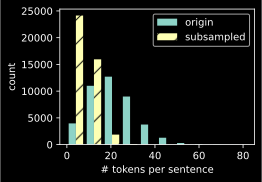

In [ ]:
# 绘制下采样前后每句话的词元数量的直方图。如预期那样，下采样通过删除高频词来显著缩短橘子，这将使得训练加速。
d2l.show_list_len_pair_hist(
    ['origin', 'subsampled'], '# tokens per sentence',
    'count', sentences, subsampled)

In [ ]:
# 对于单个词元，高频词“the”的采样率不到1/20。


def compare_counts(token):
    return (f'"{token}"的数量：'
            f'之前={sum([l.count(token) for l in sentences])}, '
            f'之后={sum([l.count(token) for l in subsampled])}')

print(compare_counts('the'))

# 相比之下，低频词“join”则被完全保留。


print(compare_counts('join'))

# 在下采样之后，我们将词元映射到它们在语料库中的索引。


corpus = [vocab[line] for line in subsampled]
print(corpus[:3])

"the"的数量：之前=50770, 之后=1998
"join"的数量：之前=45, 之后=45
[[], [392, 2115, 274, 406], [5277, 3054, 1580]]


### 中心词和上下文词的提取

下面的`get_centers_and_contexts`函数从`corpus`中提取所有中心词及其上下文词。它随机采样1到`max_window_size`之间的整数作为上下文窗口。对于任一中心词，与其距离不超过采样上下文窗口大小的词为其上下文词。


In [ ]:
def get_centers_and_contexts(corpus, max_window_size):
    """返回跳元模型中的中心词和上下文词"""
    centers, contexts = [], []
    for line in corpus:
        # 要形成”中心词-上下文词“，每个句子至少需要2个词
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # 上下文窗口中间i
            window_size = random.randint(1, max_window_size)
            indice = list(range(max(0, i - window_size), min(len(line), i + 1 + window_size)))
            # 从上下文去除中心词
            indice.remove(i)
            contexts.append([line[idx] for idx in indice])
    
    return centers, contexts

In [ ]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('数据集', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('中心词', center, '的上下文词是', context)

数据集 [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
中心词 0 的上下文词是 [1, 2]
中心词 1 的上下文词是 [0, 2, 3]
中心词 2 的上下文词是 [0, 1, 3, 4]
中心词 3 的上下文词是 [1, 2, 4, 5]
中心词 4 的上下文词是 [2, 3, 5, 6]
中心词 5 的上下文词是 [3, 4, 6]
中心词 6 的上下文词是 [4, 5]
中心词 7 的上下文词是 [8]
中心词 8 的上下文词是 [7, 9]
中心词 9 的上下文词是 [8]


In [ ]:
# 在PTB上进行训练，上下文窗口设为5，下面提取数据集中所有的中心词和上下文词。
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'中心词-上下文词对的数量： {sum([len(contexts) for contexts in all_contexts])}'

'中心词-上下文词对的数量： 1502945'

### *负采样*（不太懂）

我们使用负采样进行近似训练。为了根据预定义的分布对噪声词进行采样，我们定义以下RandomGenerator类，其中（可能未规范化的）采样分布通过变量sampling_weights传递。

In [ ]:
class RandomGenerator:
    """根据n个采样权重在{1,...,n}中随机抽取"""
    def __init__(self, sampling_weights):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # 缓存k个随机采样结果
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

对于一对中心词和上下文词，我们随机抽取了K个（实验中为5个）噪声词。根据word2vec论文中的建议，将噪声词 𝑤 的采样概率 𝑃(𝑤) 设置为其在字典中的相对频率，其幂为0.75 。

In [ ]:
def get_negatives(all_contexts, vocab, counter, K):
    """返回负采样中的噪声词"""
    # 索引为1、2、...（索引0是词表中排除的未知标记）
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # 噪声词不能是上下文词
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

### 小批量加载训练实例

在提取所有中心词及其上下文词和采样噪声词后，将它们转换成小批量的样本，在训练过程中可以迭代加载。

在小批量中，$i^\mathrm{th}$个样本包括中心词及其$n_i$个上下文词和$m_i$个噪声词。由于上下文窗口大小不同，$n_i+m_i$对于不同的$i$是不同的。因此，对于每个样本，我们在`contexts_negatives`个变量中将其上下文词和噪声词连结起来，并填充零，直到连结长度达到$\max_i n_i+m_i$(`max_len`)。为了在计算损失时排除填充，我们定义了掩码变量`masks`。在`masks`中的元素和`contexts_negatives`中的元素之间存在一一对应关系，其中`masks`中的0（否则为1）对应于`contexts_negatives`中的填充。

为了区分正反例，我们在`contexts_negatives`中通过一个`labels`变量将上下文词与噪声词分开。类似于`masks`，在`labels`中的元素和`contexts_negatives`中的元素之间也存在一一对应关系，其中`labels`中的1（否则为0）对应于`contexts_negatives`中的上下文词的正例。

上述思想在下面的`batchify`函数中实现。其输入`data`是长度等于批量大小的列表，其中每个元素是由中心词`center`、其上下文词`context`和其噪声词`negative`组成的样本。此函数返回一个可以在训练期间加载用于计算的小批量，例如包括掩码变量。


In [ ]:
def batchify(data):
    """返回带有负采样的跳元模型的小批量样本"""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += \
            [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

In [ ]:
# 使用一个小批量的两个样本来测试函数

x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


### 整合代码

In [ ]:
class PTBDataset(torch.utils.data.Dataset):
    def __init__(self, centers, contexts, negatives):
        assert len(centers) == len(contexts) == len(negatives)
        self.centers = centers
        self.contexts = contexts
        self.negatives = negatives

    def __getitem__(self, index):
        return (self.centers[index], self.contexts[index],
                self.negatives[index])

    def __len__(self):
        return len(self.centers)
        
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """下载PTB数据集，然后将其加载到内存中"""
    num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True,
        collate_fn=batchify, num_workers=num_workers)
    return data_iter, vocab

In [ ]:
# 打印数据迭代器的第一个小批量

data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])

contexts_negatives shape: torch.Size([512, 60])

masks shape: torch.Size([512, 60])

labels shape: torch.Size([512, 60])

## 应用预训练的词向量


### 加载预训练词向量

In [1]:
import os
import torch
from torch import nn
from d2l import torch as d2l

以下列出维度为50、100和300的预训练GloVe嵌入，可从GloVe网站下载。预训练的fastText嵌入有多种语言。这里我们使用可以从fastText网站下载300维度的英文版本（“wiki.en”）。

In [2]:
d2l.DATA_HUB['glove.6b.50d'] = (d2l.DATA_URL + 'glove.6B.50d.zip',
                                '0b8703943ccdb6eb788e6f091b8946e82231bc4d')

d2l.DATA_HUB['glove.6b.100d'] = (d2l.DATA_URL + 'glove.6B.100d.zip',
                                 'cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a')

d2l.DATA_HUB['glove.42b.300d'] = (d2l.DATA_URL + 'glove.42B.300d.zip',
                                  'b5116e234e9eb9076672cfeabf5469f3eec904fa')

d2l.DATA_HUB['wiki.en'] = (d2l.DATA_URL + 'wiki.en.zip',
                           'c1816da3821ae9f43899be655002f6c723e91b88')

为了加载预训练的GloVe和fastText嵌入，定义一个TokenEmbedding类。

In [4]:
class TokenEmbedding:
    """GloVe嵌入"""
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        data_dir = d2l.download_extract(embedding_name)
        # GloVe网站：https://nlp.stanford.edu/projects/glove/
        # fastText网站：https://fasttext.cc/
        with open(os.path.join(data_dir, 'vec.txt'), 'r') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # 跳过标题信息，例如fastText中的首行
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

In [5]:
# 加载50维GloVe嵌入
glove_50d = TokenEmbedding('glove.6b.50d')

# 词表包含400000个词和一个特殊的未知词元
print(len(glove_50d))

400001


In [7]:
glove_50d.token_to_idx['<unk>'], glove_50d.idx_to_token[0]

(0, '<unk>')

In [9]:
glove_50d.idx_to_vec[0].shape

torch.Size([50])

## BERT

BERT和Word2Vec以及GloVe的区别在于，BERT是上下文敏感的。

[BERT](./BERT/)

# NLP：应用

NLP的任务流程图：
<center><img src='https://zh-v2.d2l.ai/_images/nlp-map-app.svg' /><center/>